In [31]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io.wavfile
%matplotlib inline
from sklearn.decomposition import FastICA, PCA

In [32]:
#setup data for ICA
sound1 = np.loadtxt('sounds/sound1.dat')
sound2 = np.loadtxt('sounds/sound2.dat')
sounds = np.concatenate([[sound1, sound2]], axis=1)

As = np.zeros([100,2,2])
n = As.shape[0] 
for i in np.arange(n):
    A = np.linalg.inv(np.random.RandomState().rand(2,2))
    As[i] = A
    
# A = np.linalg.inv(np.random.RandomState(seed+4).rand(2,2))

# X0 = A.dot(sounds)

In [33]:
# (From previous exercises) setup functions for ICA
def sigmoid(y):
    return 0.5*np.tanh(0.5*y)+0.5

def psi(y):
    return 1 - 2 * sigmoid(y)

def update_natural(W, x):
    n = x.shape[0]
    
    phee = psi(W.dot(x)).reshape(n, 1)
    assert np.sum(np.isnan(phee)) == 0
    delta_W = np.dot(phee.dot(np.dot(W, x).reshape(1, n)), W)
    assert np.sum(np.isnan(delta_W)) == 0
    delta_W = delta_W + W  # multiplied out delta function
    assert np.sum(np.isnan(delta_W)) == 0
    for i in range(n):  # Bell-Sejnowski solution
        delta_W[i, i] = 0
    return delta_W

def plot(ax, data, **kwargs):
    ax.plot(data, **kwargs)
    ax.set_title(kwargs['label'])
    scipy.io.wavfile.write(kwargs['label'] + '.wav', 8192, data),

def online_ica(X0, lambda_= 0.9999, epsilon = 0.001, eta = 0.01):
    X = X0[:,np.random.RandomState(seed+1).permutation(X0.shape[1])]
    X -= X.mean(axis=1).reshape((2, 1))
    
    n = X.shape[0]  # Number of sources
    W = np.linalg.inv(np.random.RandomState(seed+1).rand(n, n))
    for i in range(n):  # Bell-Sejnowski solution
        W[i, i] = 1
    time = 0
    while eta > epsilon:
        example = X.T[time % X.shape[1]]
        eta = eta * lambda_
        W += eta * update_natural(W, example)
        time += 1
#     print("Calculated unmixing matrix in {} steps".format(time))
    return W.dot(X0)

def fast_ica(X):
    ica = FastICA(n_components=2)
    S_ = ica.fit_transform(X.T)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    return S_.T #return unmixed signals

seed = 13  # seed for random states to get always the same result

In [34]:
times = np.zeros([n,2])
dets = np.zeros([n,1])

for i, A in enumerate(As):

    
    dets[i] = np.linalg.det(A)
    X = A.dot(sounds)
    start_time = time.time()
    unmixed_onlineica = online_ica(X)
    times[i,0] = (time.time() - start_time)
#     print("online ica took %s seconds" % (time.time() - start_time))

    start_time = time.time()
    unmixed_fastica = fast_ica(X)
    times[i,1] = (time.time() - start_time)
#     print("fast ica took %s seconds" % (time.time() - start_time))


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in add


AssertionError: 

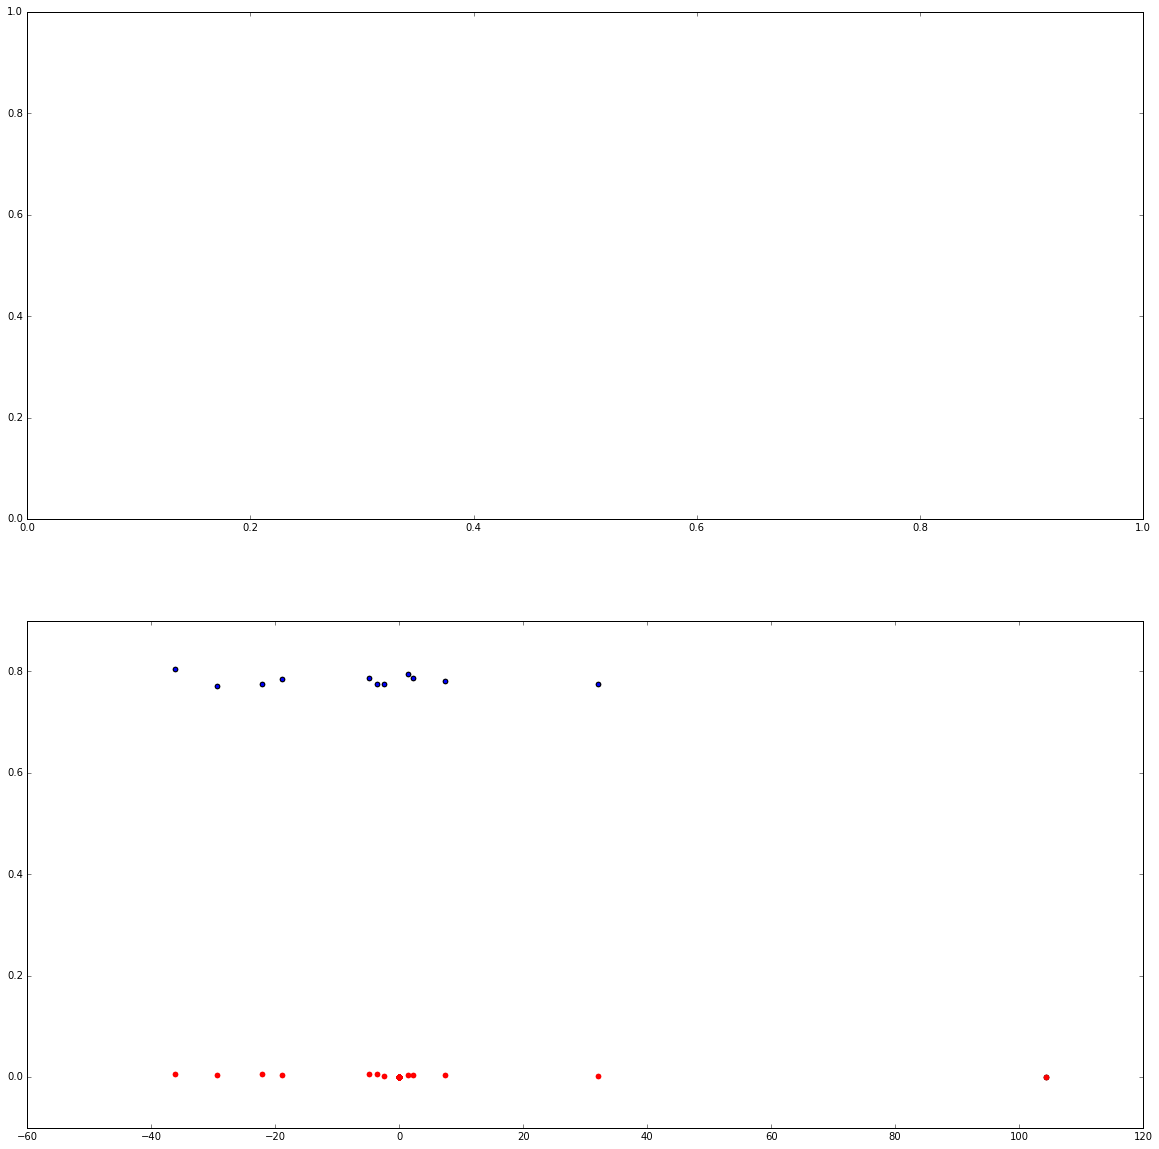

In [35]:
# times[:,0].shape
fig, ax = plt.subplots(nrows=2,figsize=(20,20))

ax[0] = plt.scatter(dets,times[:,0])
plt.scatter(dets,times[:,1],color='red')

ax[1] = plt.scatter(dets,times[:,0])
plt.scatter(dets,times[:,1],color='red')

In [ ]:
# fig, ax = plt.subplots(3, 2, figsize=(13, 8))
# plot(ax[0, 0], sound1, label='Source 1')
# plot(ax[0, 1], sound2, label='Source 2')
# plot(ax[1, 0], unmixed_onlineica[0,:], label='Unmixed 1 (infomax)', color='green')
# plot(ax[1, 1], unmixed_onlineica[1,:], label='Unmixed 2 (infomax)', color='green')
# plot(ax[2, 0], unmixed_fastica[0,:], label='Unmixed 1 (fastICA)', color='yellow')
# plot(ax[2, 1], unmixed_fastica[1,:], label='Unmixed 2 (fastICA)', color='yellow')
# fig.tight_layout()